In [3]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import time
from collections import defaultdict

(1, 480, 640, 3)


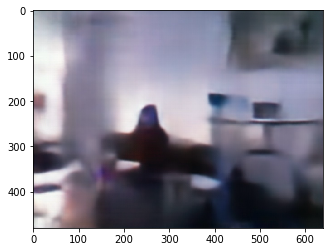

In [6]:
img = cv2.imread('img.jpg')
plt.imshow(img)
img = img.reshape(1,img.shape[0],img.shape[1],img.shape[2])
print (img.shape)




In [3]:
def convolution(inp):
    print ("insideFunction")
    return tf.layers.conv2d(inputs=inp,filters =32, kernel_size = (3,3),padding = 'same',activation = None,dilation_rate =1)



def aggregatedConvolutionBN_(x,filters,isTraining,kernelList=[[(3,3)],[(3,3)]],scope= "AggregatedConv",activation= None,subSample = False):
    
    #data = tf.stack([x,x,x],axis = 0)

    data =np.array([0,1,2])
    #data = [(3,3),(5,5),(7,7)]
    #print (data)
    #print (data.shape)
    #ch = 1
    #convFunctions =[]
#     for kl in GlobalKernels:
#         for i in range(1,DilationLevels+1):
#             fn = lambda : tf.layers.conv2d(inputs=x,filters =filters, kernel_size = kl,padding = 'same',activation = None,dilation_rate =i)   
#             convFunctions.append(fn)
        
    def hardcodedConvolution(inp):
#         caseDict = {}
#         for i in range(len(convFunctions)) :
#             caseDict[tf.equal(inp,i)] = convFunctions[i]
        #return convFunctions[inp]()
        
        return tf.case({tf.equal(inp,0):lambda : tf.layers.conv2d(inputs=x,filters =filters, kernel_size = (3,3),padding = 'same',activation = None,dilation_rate =1),tf.equal(inp,1):lambda : tf.layers.conv2d(inputs=x,filters =filters, kernel_size = (5,5),padding = 'same',activation = None,dilation_rate =1),tf.equal(inp,2):lambda : tf.layers.conv2d(inputs=x,filters =filters, kernel_size = (7,7),padding = 'same',activation = None,dilation_rate =1) },exclusive =True)   
    L = tf.map_fn(hardcodedConvolution,data,dtype = tf.float32,parallel_iterations= 25)
    return L
def aggregatedConvolutionBN(x,filters,isTraining,kernelList=[[(3,3),(5,5),(7,7)]],scope= "AggregatedConv",activation= None,subSample=0):
    
    with tf.variable_scope(scope):
        featureMapList = []
        dilationRate =0
        for kernels in kernelList :
            dilationRate +=1
            for kernel in kernels:
                featureMapList.append(tf.layers.conv2d(inputs=x,filters =filters, kernel_size = kernel,padding = 'same',activation = None,dilation_rate = dilationRate))    
        
        featureMap  = tf.concat (featureMapList,axis =-1) 
        featureMap  = tf.layers.batch_normalization(featureMap,training = isTraining)
        if not activation is None :
            
            featureMap = activation(featureMap)
        if subSample :
            featureMap = tf.layers.conv2d(inputs = featureMap,filters = featureMap.shape[-1]//2,kernel_size = (3,3),padding = 'same',activation = activation,strides=(subSample))  
        return featureMap
    

In [4]:
def aggregatedTransposedConvolutionBN(x,filters,isTraining,kernelList=[(3,3),(7,7),(11,11)],scope= "AggregatedTransposedConv",activation= None,superSample=0):
    with tf.variable_scope(scope):
        featureMapList = []
        for kernel in kernelList:
            featureMapList.append(tf.layers.conv2d_transpose(inputs=x,filters =filters, kernel_size = kernel,padding = 'same',activation = None,strides = superSample))    
        
        featureMap  = tf.concat (featureMapList,axis =-1) 
        featureMap  = tf.layers.batch_normalization(featureMap,training = isTraining)
        if not activation is None :
            featureMap = activation(featureMap)    
        return featureMap

In [1]:
def EncoderBlockBase2 (x,training,scope):
    with tf.variable_scope(scope):
        out = aggregatedConvolutionBN(x,32,training,kernelList =KERNELS,scope = 'conv1',activation = tf.nn.relu,subSample =2)   
        out = aggregatedConvolutionBN(out,32,training,kernelList =KERNELS,scope = 'conv2',activation = None)   
        shortcut = tf.layers.conv2d(x,out.shape[-1],kernel_size= (3,3),padding = "same",strides= (2,2))
        out = tf.nn.relu(out+shortcut)
    return out
def EncoderBlockBase4(x,training,scope):
    with tf.variable_scope(scope):
        
def DecoderBlockBase2 (x,training,scope):
    with tf.variable_scope(scope):
        out = aggregatedTransposedConvolutionBN(x,48,training,kernelList = DECODER_KERNELS,scope= "convDecoder1",activation = tf.nn.relu,superSample=2)   
        out = aggregatedConvolutionBN(out,48,training,kernelList =KERNELS,scope = 'convDecoder2',activation = None)   
        shortcut = tf.layers.conv2d_transpose(x,out.shape[-1],kernel_size= (3,3),padding = "same",strides= (2,2))
        out =tf.nn.relu(out + shortcut)
    return out

IndentationError: expected an indented block (<ipython-input-1-27a0eb9f7d4e>, line 10)

In [7]:
tf.reset_default_graph()
GlobalKernels = [(3,3),(5,5),(7,7),(11,11)]#,(13,13),(15,15),(17,17),(21,21)]
DilationLevels =3
inputs_= tf.placeholder(dtype= tf.float32,shape = [None,img.shape[1],img.shape[2],img.shape[3]])
training = tf.placeholder(dtype=tf.bool)
KERNELS = [[(3,3),(7,7),(11,11)],[(5,5),(7,7)],[(7,7),(9,9)]]
DECODER_KERNELS = [(3,3),(7,7),(11,11)]
#convResult = aggregatedConvolutionBN_(inputs_,32,training,kernelList = [[(3,3),(7,7),(11,11)],[(5,5),(7,7)],[(7,7),(9,9)]],scope = 'conv1',activation = tf.nn.relu,subSample =4)   
convResult = EncoderBlockBase2(inputs_,training,"Encoder1_Base2")
convResult = EncoderBlockBase2(convResult,training,"Encoder2_Base2")
convResult = EncoderBlockBase2(convResult,training,"Encoder3_Base2")
convResult = EncoderBlockBase2(convResult,training,"Encoder4_Base2")
decResult  = DecoderBlockBase2(convResult,training,"Decoder1_Base2")
decResult  = DecoderBlockBase2(decResult,training,"Decoder2_Base2")
decResult  = DecoderBlockBase2(decResult,training,"Decoder3_Base2")
decResult  = DecoderBlockBase2(decResult,training,"Decoder4_Base2")
loss = tf.square(decResult)
opti = tf.train.AdamOptimizer()
trainables = opti.minimize(loss)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    out = sess.run([convResult,decResult],feed_dict={inputs_ : img,training :True})
    start = time.time()
    out = sess.run([convResult,decResult,loss],feed_dict={inputs_ : img,training :True})
    print ("Time ", time.time()-start)
    #_ = sess.run(trainables,feed_dict={inputs_:img,training:True})


Time  0.9246864318847656


In [8]:
print (out[0].shape)
print (out[1].shape)
print (_)

(1, 30, 40, 224)
(1, 480, 640, 336)



In [6]:
print(type(inputs_))

<class 'tensorflow.python.framework.ops.Tensor'>


In [71]:
kernelList = [[(3,3),(7,7),(11,11)],[(5,5),(7,7)],[(7,7),(9,9)]]

In [39]:
class architecture():
    def __init__(self,encoder_kernels,decoder_kernels):
        self.ENCODER_KERNELS = encoder_kernels
        self.DECODER_KERNELS = decoder_kernels
        
    def aggregatedConvolutionBN(self,x,filters,isTraining,kernelList=[[(3,3),(5,5),(7,7)]],scope= "AggregatedConv",activation= None,subSample=0):
        with tf.variable_scope(scope):
            featureMapList = []
            dilationRate =0
            for kernels in kernelList :
                dilationRate +=1
                for kernel in kernels:
                    featureMapList.append(tf.layers.conv2d(inputs=x,filters =filters, kernel_size = kernel,padding = 'same',activation = None,dilation_rate = dilationRate))    

            featureMap  = tf.concat (featureMapList,axis =-1) 
            featureMap  = tf.layers.batch_normalization(featureMap,training = isTraining)
            if not activation is None :

                featureMap = activation(featureMap)
            if subSample :
                featureMap = tf.layers.conv2d(inputs = featureMap,filters = featureMap.shape[-1],kernel_size = (3,3),padding = 'same',activation = activation,strides=subSample)  
            return featureMap
        
    def aggregatedTransposedConvolutionBN(self,x,filters,isTraining,kernelList=[(3,3),(7,7),(11,11)],scope= "AggregatedTransposedConv",activation= None,superSample=0):
        with tf.variable_scope(scope):
            featureMapList = []
            for kernel in kernelList:
                featureMapList.append(tf.layers.conv2d_transpose(inputs=x,filters =filters, kernel_size = kernel,padding = 'same',activation = None,strides = superSample))    

            featureMap  = tf.concat (featureMapList,axis =-1) 
            featureMap  = tf.layers.batch_normalization(featureMap,training = isTraining)
            if not activation is None :
                featureMap = activation(featureMap)    
            return featureMap
    
    def EncoderBlockBase2 (self,x,filters,training,scope):
        with tf.variable_scope(scope):
            out = self.aggregatedConvolutionBN(x,filters,training,kernelList =self.ENCODER_KERNELS,scope = 'EncConv1_b2',activation = tf.nn.relu,subSample =2)   
            out = self.aggregatedConvolutionBN(out,filters,training,kernelList =self.ENCODER_KERNELS,scope = 'EncConv2_b2',activation = None)   
            shortcut = tf.layers.conv2d(x,out.shape[-1],kernel_size= (3,3),padding = "same",strides= (2,2))
            out = tf.nn.relu(out+shortcut)
        return out
    def EncoderBlockBase4 ( self,x,filters,training,scope):
        with tf.variable_scope(scope):
            out = self.aggregatedConvolutionBN(x,filters,training,kernelList =self.ENCODER_KERNELS,scope = 'EncConv1_b4',activation = tf.nn.relu,subSample =4)   
            out = self.aggregatedConvolutionBN(out,filters,training,kernelList =self.ENCODER_KERNELS,scope = 'EncConv2_b4',activation = tf.nn.relu)   
            out = self.aggregatedConvolutionBN(out,filters,training,kernelList =self.ENCODER_KERNELS,scope = 'EncConv3_b4',activation = None)   
            shortcut = tf.layers.conv2d(x,out.shape[-1],kernel_size= (3,3),padding = "same",strides= (4,4))
            out = tf.nn.relu(out+shortcut)
        return out
    
    def DecoderBlockBase2 (self,x,filters,training,scope):
        with tf.variable_scope(scope):
            out = self.aggregatedTransposedConvolutionBN(x,filters,training,kernelList = self.DECODER_KERNELS,scope= "DecConv1_b2",activation = tf.nn.relu,superSample=2)   
            out = self.aggregatedConvolutionBN(out,filters,training,kernelList =self.ENCODER_KERNELS,scope = 'DecConv2_b2',activation = None)   
            shortcut = tf.layers.conv2d_transpose(x,out.shape[-1],kernel_size= (3,3),padding = "same",strides= (2,2))
            out =tf.nn.relu(out + shortcut)
        return out
    
    def DecoderBlockBase4 (self,x,filters,training,scope):
        with tf.variable_scope(scope):
            out = self.aggregatedTransposedConvolutionBN(x,filters,training,kernelList = self.DECODER_KERNELS,scope= "DecConv1_b4",activation = tf.nn.relu,superSample=4)   
            out = self.aggregatedConvolutionBN(out,filters,training,kernelList =self.ENCODER_KERNELS,scope = 'DecConv2_b4',activation = tf.nn.relu)   
            out = self.aggregatedConvolutionBN(out,filters,training,kernelList =self.ENCODER_KERNELS,scope = 'DecConv3_b4',activation = None)   
            shortcut = tf.layers.conv2d_transpose(x,out.shape[-1],kernel_size= (3,3),padding = "same",strides= (4,4))
            out =tf.nn.relu(out + shortcut)
        return out
    
    def buildNetwork_base2(self,x,phase,scope):
        with tf.variable_scope(scope):
            enc1 = self.EncoderBlockBase2(   x,8,phase,"Encoder1_Base2")
            enc2 = self.EncoderBlockBase2(enc1,16,phase,"Encoder2_Base2")
            enc3 = self.EncoderBlockBase2(enc2,32,phase,"Encoder3_Base2")
            enc4 = self.EncoderBlockBase2(enc3,48,phase,"Encoder4_Base2")
            dec4 = self.DecoderBlockBase2(enc4,32,phase,"Decoder1_Base2")
            dec3 = self.DecoderBlockBase2(dec4 + enc3,16,phase,"Decoder2_Base2")
            dec2 = self.DecoderBlockBase2(dec3 + enc2,8,phase,"Decoder3_Base2")
            dec1 = self.DecoderBlockBase2(dec2 + enc1,8,phase,"Decoder4_Base2")
            logits =tf.layers.conv2d(dec1,filters=3,padding="same",activation = None,kernel_size = (5,5),name= "preFinal")
            logits =tf.layers.conv2d(logits,filters=3,padding = "same",activation = None,kernel_size = (3,3),name= "logits")
            return logits
    
    def buildNetwork_base4(self,x,phase,scope):
    
        with tf.variable_scope(scope):
            ''' Encoder structure'''
            enc1 = self.EncoderBlockBase2(   x,8,phase,"Encoder1_Base2")
            enc2a = self.EncoderBlockBase2(enc1,16,phase,"Encoder2_Base2")
            enc2b = self.EncoderBlockBase4(x,16,phase,"Encoder1_Base4")
            enc2 = tf.concat([enc2a,enc2b],axis =-1)
            enc3 = self.EncoderBlockBase2(enc2,32,phase,"Encoder3_Base2")
            enc4a = self.EncoderBlockBase2(enc3,32,phase,"Encoder4_Base2")
            enc4b = self.EncoderBlockBase4(enc2,32,phase,"Encoder2_Base4")
            enc4 = tf.concat([enc4a,enc4b],axis =-1)
            
            ''' Decoder structure'''
            dec4 = self.DecoderBlockBase2(enc4,32,phase,"Decoder1_Base2")
            dec3a = self.DecoderBlockBase2(dec4 + enc3,16,phase,"Decoder2_Base2")
            dec3b =  self.DecoderBlockBase4(enc4,16,phase,"Decoder1_Base4")
            dec3 = tf.concat([dec3a,dec3b],axis=-1)
            dec2 = self.DecoderBlockBase2(dec3 + enc2,8,phase,"Decoder3_Base2")
            dec1a = self.DecoderBlockBase2(dec2 + enc1,8,phase,"Decoder4_Base2")
            dec1b = self.DecoderBlockBase4(dec3,8,phase,"Decoder2_Base4")
            dec1 = tf.concat([dec1a,dec1b],axis = -1)
            logits =tf.layers.conv2d(dec1,filters=3,padding="same",activation = None,kernel_size = (5,5),name= "preFinal")
            logits =tf.layers.conv2d(logits,filters=3,padding = "same",activation = None,kernel_size = (3,3),name= "logits")
            return logits
    
        
        



In [40]:
tf.reset_default_graph()
model = architecture([[(3,3),(7,7),(11,11)],[(5,5),(7,7)],[(7,7),(9,9)]],[(3,3),(7,7),(11,11)])
inputs_= tf.placeholder(dtype= tf.float32,shape = [None,img.shape[1],img.shape[2],img.shape[3]])
training = tf.placeholder(dtype=tf.bool)
out = model.buildNetwork_base4(inputs_,training,"Arch1")

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    o = sess.run([out],feed_dict={inputs_ : img,training :True})
    start = time.time()
    o= sess.run([out],feed_dict={inputs_ : img,training :True})
    print ("Time ", time.time()-start)

Time  0.23999381065368652


In [41]:
print (o[0].shape)

(1, 480, 640, 3)
